<a href="https://colab.research.google.com/github/Segtanof/pyfin/blob/main/08_Regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressions
Useful links:
- https://aeturrell.github.io/coding-for-economists/econmt-regression.html
<!-- - https://aeturrell.github.io/python4DS/quarto.html -->

We need to install some packages.
We use `pyfixest` for regressions and `pingouin` for ttests / correlation analyses.

In [2]:
pip install pyfixest

Note: you may need to restart the kernel to use updated packages.


In [3]:
# General packages
import pandas as pd
import numpy as np
import seaborn as sns

# Regression-specific packages
import pyfixest as pf
import pingouin as pg

In [4]:
# We load a dataset of NYC taxi trips
# Source: https://github.com/mwaskom/seaborn-data

# Note that we drop rows that have any missing values
data = sns.load_dataset("taxis").dropna(how='any')

In [5]:
data.sample(3)

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
5867,2019-03-26 14:14:17,2019-03-26 14:24:09,1,1.59,8.5,0.00,0.0,9.30,green,cash,Central Harlem,Central Harlem North,Manhattan,Manhattan
2736,2019-03-05 09:44:10,2019-03-05 09:54:06,5,1.09,7.5,2.16,0.0,12.96,yellow,credit card,Midtown North,Lincoln Square West,Manhattan,Manhattan
4370,2019-03-19 22:17:13,2019-03-19 22:22:38,1,1.60,7.0,2.00,0.0,12.80,yellow,credit card,Two Bridges/Seward Park,Gramercy,Manhattan,Manhattan


## T-test
A common hypothesis test is the t-test.
We can check whether the mean of an array differs from a value as follows.

Let's check if `tolls` are significantly different from `0`.

In [6]:
value_to_test_against = 0
pg.ttest(data['tolls'], value_to_test_against)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,18.308157,6340,two-sided,5.280784e-73,"[0.28, 0.35]",0.229914,1.11e+69,1.0


Interpretation: We do not find support for the null-hypothesis of `tolls` being equal to `0` and thus reject it. We can see this from the t statistic being larger than the critical value, or, equivalently, the `p-val` being lower than common significance thresholds.

If we arbitrarily limit the number of observations by taking a random `sample`, we can see more uncertainty.

Because it's a random sample, you won't see the exact same values.

In [7]:
sample = data['tolls'].sample(50)

In [8]:
pg.ttest(sample, value_to_test_against)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.333333,49,two-sided,0.023778,"[0.08, 1.07]",0.329983,1.801,0.628351


**Quick exercise**

You can see that we are running a two-sided t-test. Since tolls cannot be negative a one-sided t-test might be more appropriate.

Run a one-sided t-test.

In [9]:
value_to_test_against = 0
pg.ttest(sample, value_to_test_against, alternative="greater")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.333333,49,greater,0.011889,"[0.16, inf]",0.329983,3.603,0.744109


A more realistic test you might want to run is comparing the different trip distances based on the color of the cab.

![Taxis](https://newyorkmonamour.fr/wp-content/uploads/2016/10/boro-cabs-vs-yellow-cabs.jpg)

We can check how many observations are in each color by using the `value_counts` method:

In [10]:
data.value_counts(subset="color")

color
yellow    5373
green      968
Name: count, dtype: int64

We can check the means in each group:

In [11]:
data.groupby("color")["distance"].mean()

color
green     3.412665
yellow    2.922948
Name: distance, dtype: float64

It looks like green taxis travel about a half-mile further than yellow taxis. But is this difference statistically significant or just a random finding?

In [12]:
yellow_distance = data.query("color == 'yellow'")['distance']
green_distance = data.query("color == 'green'")['distance']
green_distance

5451     2.29
5452     0.80
5453     1.51
5454     0.45
5455     0.61
        ...  
6428     0.75
6429    18.74
6430     4.14
6431     1.12
6432     3.85
Name: distance, Length: 968, dtype: float64

In [13]:
# This time we are using some additional keyword arguments: confidence
# Check the documentation to see what that does: https://pingouin-stats.org/build/html/generated/pingouin.ttest.html#pingouin.ttest

pg.ttest(yellow_distance, green_distance, confidence=0.99)

,T,dof,alternative,p-val,CI99%,cohen-d,BF10,power
T-test,-3.546353,1274.846737,two-sided,0.000405,"[-0.8459478061155647, -0.13348662499314595]",0.13179,20.428,0.965151


The result shows that the mean of the yellow taxis is statistically significantly less than the mean trip distance of green taxis.

**Quick exercise**

- How many unique pickup zones are in the data set?

- Check whether the `total` price paid differs between the `pickup_zone` "Yorkville East" and "Yorkville West" and whether the difference is significant at the 10% level. Show the appropriate confidence interval.

In [14]:
data["pickup_zone"].nunique()

194

In [15]:
data.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


In [16]:
yet = data.query("(pickup_zone == 'Yorkville East')")["total"]
yet.mean()

15.59285714285714

In [17]:
ywt = data.query("(pickup_zone == 'Yorkville West')")["total"]
ywt.mean()

14.948415841584158

In [18]:
pol = ["Yorkville West", "Yorkville East"]
data.query("pickup_zone in @pol").groupby("pickup_zone")["total"].mean()

pickup_zone
Yorkville East    15.592857
Yorkville West    14.948416
Name: total, dtype: float64

In [19]:
pg.ttest(yet, ywt, confidence=.9)

,T,dof,alternative,p-val,CI90%,cohen-d,BF10,power
T-test,0.624414,149.153958,two-sided,0.533309,"[-1.0637778932951096, 2.3526604958410737]",0.096997,0.201,0.095092


## Linear regression

### Basics

Let's try to see if we can figure out the pricing structure.
In order to do that, t-tests are not sufficient, because we need to consider more than a single variable.

Typically, taxi fares start at a base fare, a per-mile rate, and a time component. In NYC, there are [other components](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page) as well.

From those three components, we can easily observe the base fare (intercept) and the per-mile rate (distance).

In order to specify the regression equation, we use the `~` (tilda) operator to separate the left- and right-hand sides of the regression equation.

We then add the variable names (column names) from our data. **Avoid spaces in the column names!**

To regress `y` on `x`, use `y ~ x`, which covers the regression equation $y = a + \beta x + \epsilon$. An intercept is added automatically. If you do not want to add an intercept, set the keyword argument `drop_intercept=True`.

In [20]:
pf.feols("fare ~ distance", data=data).summary()

###

Estimation:  OLS
Dep. var.: fare, Fixed effects: 0
Inference:  iid
Observations:  6341

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      4.697 |        0.055 |    85.292 |      0.000 |  4.589 |   4.805 |
| distance      |      2.732 |        0.012 |   237.047 |      0.000 |  2.710 |   2.755 |
---
RMSE: 3.414 R2: 0.899 


It looks like the base fare is \$4.7 and a charge of \$2.73 is added per mile.
Our estimates are statistically significant and we can explain about 90% of the variance in the data.

**Quick exercise**

- Write the regression formula for the regression equation $R_t = a + \beta R_M + \epsilon$
- Make a scatterplot. `tip` against `distance`. What do you notice?
- Run a regression for $tip = a + \beta \times distance + \epsilon$
- Run a regression for $tip = \beta \times distance + \epsilon$

In [21]:
"rt ~ rm"

'rt ~ rm'

<Axes: xlabel='distance', ylabel='tip'>

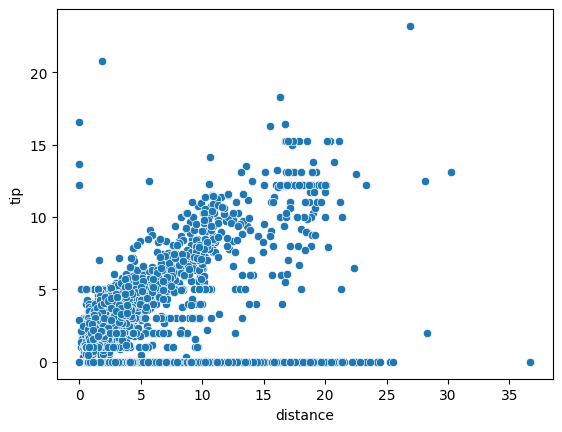

In [22]:
sns.scatterplot(data=data, x="distance", y="tip")

In [23]:
pf.feols("tip ~ distance", data = data).summary()

###

Estimation:  OLS
Dep. var.: tip, Fixed effects: 0
Inference:  iid
Observations:  6341

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      1.065 |        0.033 |    31.800 |      0.000 |  0.999 |   1.130 |
| distance      |      0.303 |        0.007 |    43.208 |      0.000 |  0.289 |   0.317 |
---
RMSE: 2.076 R2: 0.228 


In [24]:
pf.feols("tip ~ distance", data = data, drop_intercept=True).summary()

###

Estimation:  OLS
Dep. var.: tip, Fixed effects: 0
Inference:  iid
Observations:  6341

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| distance      |      0.443 |        0.006 |    75.342 |      0.000 |  0.431 |   0.454 |
---
RMSE: 2.235 R2: 0.104 


#### New variables
Very often, you will need to construct your own variables.





**Trip duration**

Since we know the time of pickup and dropoff, we can calculate the duration of the trip.
We first take the difference between the two columns, and then use the `.dt` (datetime) [accessor of the resulting column](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html) (which is the type pandas.Series). In the next step we pull out the seconds and divide them by 60 to get minutes. Then we store it as `duration_min`. Note that we avoid spaces in the column names.

**Time-of-day surcharges**
```txt
Plus $1.00 overnight surcharge 8pm to 6am.
Plus $2.50 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.
```

[There are some surcharges](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page) depending on the time of day.


In [25]:
(pd.Timestamp("2030-06-20 13:01:32") - pd.Timestamp("2030-06-20 10:16:40")).seconds

9892

In [26]:
def is_rushhour(date):
  if date.dayofweek <= 4:
    if date.hour >= 16 and date.hour < 20:
      return True

  # Note that we do not need to specify all the `else` statements
  return False

In [27]:
data

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,East Harlem North,Central Harlem North,Manhattan,Manhattan
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,Jamaica,East Concourse/Concourse Village,Queens,Bronx
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,Crown Heights North,Bushwick North,Brooklyn,Brooklyn
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,East New York,East Flatbush/Remsen Village,Brooklyn,Brooklyn


In [28]:
data_with_added_variables = data.assign(

    # Weekend
    weekend = lambda df: df['pickup'].dt.dayofweek >= 5,

    # Duration in minutes
    duration_min = lambda df: (df['dropoff']-df['pickup']).dt.seconds/60,

    # Time-of-day surcharges
    overnight = lambda df: ((df['pickup'].dt.hour >= 20) | (df['pickup'].dt.hour <= 6)),
    rushhour = lambda df: df['pickup'].apply(is_rushhour),
    )

data_with_added_variables.head(2)

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,weekend,duration_min,overnight,rushhour
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan,True,6.250000,True,False
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan,False,7.083333,False,True


**Expensive areas**

[This source](https://www.roadwaymoving.com/blog/most-expensive-neighborhoods-in-nyc/) provides a list of NYC's most expensive neighbourhoods.
We want to add a variable that tells us if a trip started in one of these expensive areas.

In [29]:
expensive_areas = {"pickup_zone":['TriBeCa/Civic Center', 'Central Park', 'Times Sq/Theatre District', 'SoHo', 'Little Italy/NoLiTa', 'West Chelsea/Hudson Yards']}
expensive_areas = pd.DataFrame(expensive_areas).assign(expensive = True)
expensive_areas

,pickup_zone,expensive
0,TriBeCa/Civic Center,True
1,Central Park,True
2,Times Sq/Theatre District,True
3,SoHo,True
4,Little Italy/NoLiTa,True
5,West Chelsea/Hudson Yards,True


In [30]:
# We need to merge how='left'
data_with_added_variables = data_with_added_variables.merge(expensive_areas, how='left',on='pickup_zone')

data_with_added_variables.head(2)

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,weekend,duration_min,overnight,rushhour,expensive
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan,True,6.250000,True,False,NaN
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan,False,7.083333,False,True,NaN


Due to the `how='left'` merge, we have a lot of missing values (NaN). We want to fill them. Thus, we use the `fillna()` method on that column.

In [31]:
data_with_added_variables['expensive'] = data_with_added_variables['expensive'].fillna(False)
data_with_added_variables.head(2)

C:\Users\godfr\AppData\Local\Temp\ipykernel_41260\3591545572.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_with_added_variables['expensive'] = data_with_added_variables['expensive'].fillna(False)


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,weekend,duration_min,overnight,rushhour,expensive
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan,True,6.250000,True,False,False
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan,False,7.083333,False,True,False


**Using the new variables in a regression**

Let's try to see if the fare can be predicted based on the `distance` and our new variables.

In [32]:
pf.feols("fare ~ distance + duration_min + overnight + rushhour", data=data_with_added_variables).summary()

###

Estimation:  OLS
Dep. var.: fare, Fixed effects: 0
Inference:  iid
Observations:  6341

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      2.622 |        0.068 |    38.356 |      0.000 |  2.488 |   2.756 |
| distance      |      1.928 |        0.016 |   117.088 |      0.000 |  1.895 |   1.960 |
| duration_min  |      0.316 |        0.005 |    59.200 |      0.000 |  0.305 |   0.326 |
| overnight     |     -0.112 |        0.079 |    -1.417 |      0.157 | -0.266 |   0.043 |
| rushhour      |     -0.060 |        0.094 |    -0.632 |      0.528 | -0.244 |   0.125 |
---
RMSE: 2.707 R2: 0.936 


**Quick exercise**

Only some variables are significant predictors of the fare. Many are not.

Since they are called "surcharges", maybe they don't count towards the fare, but rather towards the total? Run that regression and interpret your results.

In [33]:
pf.feols("total ~ distance + duration_min + overnight + rushhour", data=data_with_added_variables).summary()

###

Estimation:  OLS
Dep. var.: total, Fixed effects: 0
Inference:  iid
Observations:  6341

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      6.252 |        0.109 |    57.218 |      0.000 |  6.038 |   6.466 |
| distance      |      2.456 |        0.026 |    93.363 |      0.000 |  2.405 |   2.508 |
| duration_min  |      0.306 |        0.009 |    35.832 |      0.000 |  0.289 |   0.322 |
| overnight     |      0.332 |        0.126 |     2.638 |      0.008 |  0.085 |   0.579 |
| rushhour      |      1.158 |        0.151 |     7.690 |      0.000 |  0.863 |   1.453 |
---
RMSE: 4.326 R2: 0.888 


### Advanced

#### Interaction terms

We typically require slightly more advanced approaches to address our research question.

For example interaction terms.
Let's say we want to find out whether the tip amount is dependent on whether it's a weekend (people might be on a leisure trip and willing to tip more) and the ride starts in an expensive area (where passengers are wealthier). In addition, we also want to know whether riders from expensive areas tip differently during the weekend (because wealthier people might be more likely to go on a leisure trip).

Thus, we can interact `weekend` with `expensive`. We can do so by writing `weekend*expensive`, which adds both variables individually and their interaction term.

Unfortunately, tips are only recorded for credit card payments, thus, we need to filter the data.

In [34]:
credit_card_only = data_with_added_variables.query("payment == 'credit card'")

In [35]:
pf.feols("tip ~ fare + weekend*expensive", data=credit_card_only).summary()

# Equivalent
# pf.feols("tip ~ fare + weekend + expensive + weekend:expensive", data=credit_card_only).summary()

###

Estimation:  OLS
Dep. var.: tip, Fixed effects: 0
Inference:  iid
Observations:  4546

| Coefficient       |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept         |      0.999 |        0.050 |    19.886 |      0.000 |  0.901 |   1.098 |
| fare              |      0.126 |        0.003 |    48.916 |      0.000 |  0.121 |   0.131 |
| weekend           |      0.048 |        0.066 |     0.732 |      0.464 | -0.081 |   0.178 |
| expensive         |      0.487 |        0.123 |     3.968 |      0.000 |  0.247 |   0.728 |
| weekend:expensive |     -0.162 |        0.225 |    -0.720 |      0.472 | -0.604 |   0.280 |
---
RMSE: 1.92 R2: 0.346 


From our results, we can see that in general our hypothesis were true, except that we would have expected a positive coefficient on the interaction term as well.

**Quick exercise**

- Run the regression for the following equation: $fare = a + \beta_1 \times distance + \beta_2 \times weekend + \beta_3 \times weekend \times distance + \epsilon$. What are we measuring with the interaction term?
- Calculate the unconditional mean of `fare`. How large is the economic effect of weekend in percent of the unconditional mean? Is it statistically and economically significant? (Manually copy the coefficient for weekend).

#### Variable transformations

Using the logarithm and other transformations are also very commonly applied methods. To achieve this, you can of course create a new column in your data that has the transformation applied.

Some functions (numpy) can however also be applied in your regression equation, which can be useful.

In [36]:
pf.feols("total ~ np.log(distance+1) + tip + tolls + duration_min + overnight + rushhour", data=data_with_added_variables).summary()

###

Estimation:  OLS
Dep. var.: total, Fixed effects: 0
Inference:  iid
Observations:  6341

| Coefficient          |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept            |      1.297 |        0.106 |    12.202 |      0.000 |  1.088 |   1.505 |
| np.log(distance + 1) |      6.251 |        0.145 |    43.235 |      0.000 |  5.968 |   6.535 |
| tip                  |      1.360 |        0.022 |    63.087 |      0.000 |  1.318 |   1.402 |
| tolls                |      2.416 |        0.039 |    62.471 |      0.000 |  2.341 |   2.492 |
| duration_min         |      0.423 |        0.008 |    56.275 |      0.000 |  0.408 |   0.438 |
| overnight            |      0.727 |        0.103 |     7.029 |      0.000 |  0.524 |   0.929 |
| rushhour             |      0.908 |        0.122 |     7.473 |      0.000 |  0.670 |   1.147 |
---
RMSE: 3.488 R2: 0.927 


## Fixed effect regression

Now let's run a more advanced type of regression. Fixed effect regressions.

Typically, we have a single intercept in our regression. However, in some cases, we might want to have separate intercepts for e.g. the color of the taxis.

We can specify that by providing the pipe operator `|` after our regression specification and then listing the different variables we want to add fixed effects for.

In [37]:
pf.feols("fare ~ distance + duration_min | color", data=data_with_added_variables).summary()
# You can see that there is no intercept listed in the regression output anymore. It is subsumed by the Fixed Effect.

###

Estimation:  OLS
Dep. var.: fare, Fixed effects: color
Inference:  CRV1
Observations:  6341

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| distance      |      1.924 |        0.035 |    55.216 |      0.012 |  1.481 |   2.366 |
| duration_min  |      0.318 |        0.006 |    55.787 |      0.011 |  0.245 |   0.390 |
---
RMSE: 2.707 R2: 0.936 R2 Within: 0.936 


**Quick exercise**

Add a FE for `pickup_zone` to the regression of the `tip` on `fare`. Use the credit card only dataset.

## Prediction

Sometimes you want to have predicted values, e.g. when forecasting expected returns.

In [38]:
# Let's take the following model
model = pf.feols("fare ~ distance + duration_min | color", data=data_with_added_variables) # No .summary()!

In [39]:
# Run the `predict` method of the model.
predicted_fare = model.predict(data_with_added_variables)
predicted_fare

array([ 7.65327773,  6.35992282,  7.57617588, ..., 16.45126653,
        6.17895182, 15.11515776])

<Axes: >

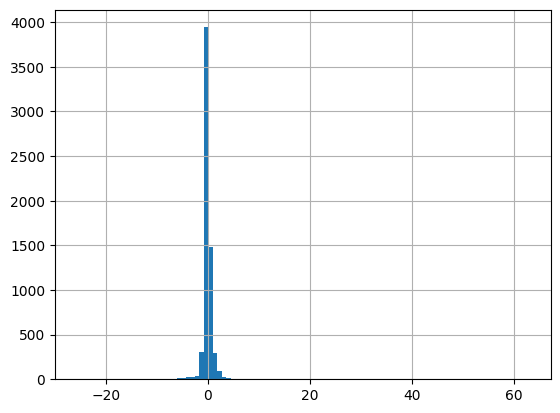

In [40]:
# We can then use the predictions in any way we want, e.g. to calculate the difference to the actual data.
data_with_added_variables['fare'].subtract(predicted_fare).hist(bins=100)

## Presenting the results

After running (multiple) regressions, you typically want to show them in an easy-to-understand way. We can use the `etable` function for this purpose.

In [41]:
# First, we run several regressions.
results = []

specifications = [
    "total ~ distance + tip + tolls*duration_min + overnight + rushhour",
    "fare ~ distance + duration_min | color + C(passengers)",
]

for spec in specifications:
  result = pf.feols(spec, data=data_with_added_variables)
  results.append(result)

In [42]:
# Second, we show the results in a nice format.
# The coef_fmt specifies that we want the t-stat in parentheses.
pf.etable(results, coef_fmt = "b (t)")

GT(_tbl_data=   level_0             level_1                   0                1
0     coef            distance   1.649*** (82.451)  1.924* (54.979)
1     coef                 tip   1.302*** (75.981)                 
2     coef               tolls   1.912*** (27.422)                 
3     coef        duration_min   0.342*** (60.961)  0.318* (55.525)
4     coef           overnight    0.467*** (5.790)                 
5     coef            rushhour    0.877*** (9.138)                 
6     coef  tolls:duration_min  -0.013*** (-7.905)                 
7     coef           Intercept   5.144*** (71.243)                 
8       fe               color                   -                x
9       fe       C(passengers)                   -                x
10   stats        Observations                6341             6341
11   stats           S.E. type                 iid        by: color
12   stats       R<sup>2</sup>               0.955            0.936, _body=<great_tables._gt_data.Body object at 0x000002565D1D4170>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002565D858140>, _spanners=Spanners([SpannerInfo(spanner_id='total', spanner_level=1, spanner_label='total', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='fare', spanner_level=1, spanner_label='fare', spanner_units=None, spanner_pattern=None, vars=['1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient (t-stats)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002565DA10F80>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_

In [43]:
# If you want to export it to Excel, you can use type='df'. There is also latex with type='tex'
pf.etable(results, coef_fmt = "b (t)", type="df")

,est1,est2
depvar,total,fare
distance,1.649*** (82.451),1.924* (54.979)
tip,1.302*** (75.981),
tolls,1.912*** (27.422),
duration_min,0.342*** (60.961),0.318* (55.525)
overnight,0.467*** (5.790),
rushhour,0.877*** (9.138),
tolls:duration_min,-0.013*** (-7.905),
Intercept,5.144*** (71.243),
color,-,x


## Exercises

a)
- Test whether passengers are different from one.
- Test whether the amount paid as fare differs between cash and credit card payments.

b) You want to study the effect of tolls on trip duration.

- Run a regression with an intercept and without an intercept.
- Plot a scatterplot that shows the relevant data

c) You're still studying the effect of tolls on trip duration.
- Run the simple regression from b with the intercept.
- Add the distance to your regression [use this spec in part d)].
- Additionally add the overnight dummy.
- Additionally add an interaction between distance and overnight.
- Additionally add a fixed effect for the taxi color.
- Collect all of these regressions into `results` and show them in a single table. Show the coefficients and the t-statistics.

d) You're still studying the effect of tolls on trip duration.
- For the regression model highlighted in part c), calculate predicted values.
- Plot predicted vs actual values in a scatterplot
  - Set the color of the points based on the pickup_borough
  - Set the marker type based on the taxi color